Loading train/test splits...
X_train shape: (3392, 15)
X_test shape: (848, 15)

Setting up Grid Search for Lasso Logistic Regression with class weighting...
Running Grid Search with class weighting...
Fitting 100 folds for each of 52 candidates, totalling 5200 fits
[CV] END C=0.9, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.9, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.9, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.9, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.9, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.9, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.9, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.9, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.9, class_weight=b

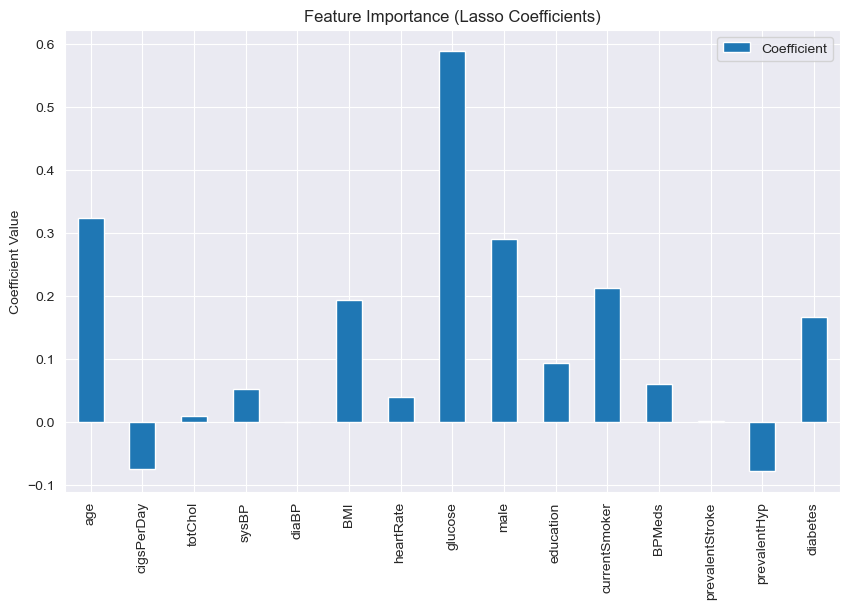

Odds Ratios:
age: 1.38
cigsPerDay: 0.93
totChol: 1.01
sysBP: 1.05
diaBP: 1.00
BMI: 1.21
heartRate: 1.04
glucose: 1.80
male: 1.34
education: 1.10
currentSmoker: 1.24
BPMeds: 1.06
prevalentStroke: 1.00
prevalentHyp: 0.93
diabetes: 1.18


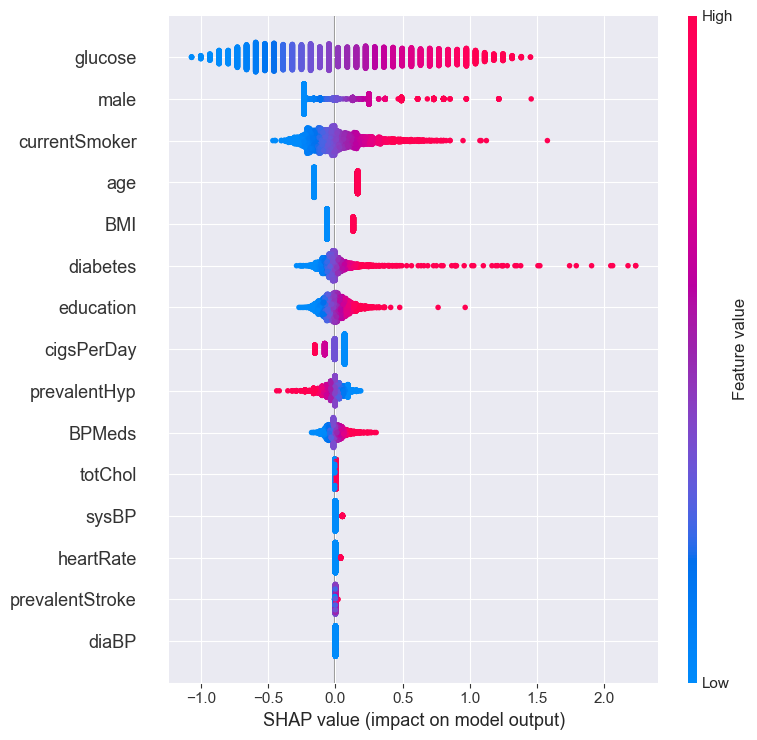

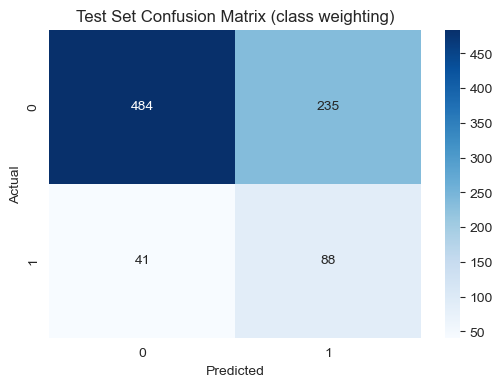


Best model with class weighting saved to ../models/lasso_best_model_weighting.pkl
Grid search results for class weighting saved to ../results/lasso_gridsearch_results_weighting.csv


In [27]:
# --- 03_lasso_regression_gridsearch_class_weight.ipynb ---

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import shap

# 1. Load preprocessed data
print("Loading train/test splits...")
X_train = np.load("../../data/splits/X_train.npy")
y_train = np.load("../../data/splits/y_train.npy")
X_test = np.load("../../data/splits/X_test.npy")
y_test = np.load("../../data/splits/y_test.npy")

# Convert numpy arrays back to pandas DataFrame
# If you saved feature names before, you should load them here.
# Let's assume the feature names are stored in 'X_train_columns' and are consistent across splits.

# Assuming X_train_columns is available (i.e., feature names)
X_train_columns = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'male', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

# Convert to DataFrame and assign columns
X_train = pd.DataFrame(X_train, columns=X_train_columns)
X_test = pd.DataFrame(X_test, columns=X_train_columns)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}\n")

# 2. Set up GridSearchCV for Lasso Logistic Regression with class weighting
param_grid = {
    #'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5,
      0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5,
      4.0, 4.5, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 15.0, 20.0,
      25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0,
      70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0, 150.0,
      200.0, 250.0, 300.0, 400.0, 500.0],  # Expanded regularization strength values

    'penalty': ['l1'],             # L1 penalty for sparsity
    'solver': ['liblinear'],       # liblinear supports l1
    'class_weight': ['balanced']   # Class weighting to handle imbalance
}

# 3. Run GridSearchCV with class weighting
print("Setting up Grid Search for Lasso Logistic Regression with class weighting...")
grid_search_weighting = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid,
    scoring='f1',  # Optimize for F1-Score (important for imbalanced data)
    cv=100,          # 5-fold cross-validation
    verbose=2,
    n_jobs=-1      # Use all cores for parallel processing
)

print("Running Grid Search with class weighting...")
grid_search_weighting.fit(X_train, y_train)

print("\nBest Parameters (class weighting):")
print(grid_search_weighting.best_params_)
print(f"Best Cross-Validated F1-Score: {grid_search_weighting.best_score_:.4f}\n")

# 4. Evaluate best model with class weighting on test set
best_model_weighting = grid_search_weighting.best_estimator_
y_test_pred_weighting = best_model_weighting.predict(X_test)

print("Test Set Results (class weighting):")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_weighting):.4f}")
print()
print("Classification Report (class weighting):")
print(classification_report(y_test, y_test_pred_weighting))

# ==============================
# Sparsity and Feature Importance
# ==============================
# Get the coefficients of the features in the final model (non-zero features are important)
coefficients = pd.DataFrame(best_model_weighting.coef_[0], index=X_train.columns, columns=['Coefficient'])

# Get non-zero coefficients (sparse features)
non_zero_coeffs = coefficients[coefficients['Coefficient'] != 0]

# Count the number of selected features (non-zero coefficients)
num_selected_features = len(non_zero_coeffs)
print(f"Number of selected features (non-zero coefficients): {num_selected_features}")

# Count the number of unselected features (zero coefficients)
num_zero_coeffs = len(coefficients) - num_selected_features
print(f"Number of unselected features (zero coefficients): {num_zero_coeffs}")

# Optionally, print out the names of the selected and unselected features
print("Selected features:")
print(non_zero_coeffs.index.tolist())

print("Unselected features:")
unselected_features = coefficients[coefficients['Coefficient'] == 0].index.tolist()
print(unselected_features)



# Plot the coefficients (feature importance)
coefficients.plot(kind='bar', figsize=(10,6))
plt.title('Feature Importance (Lasso Coefficients)')
plt.ylabel('Coefficient Value')
plt.show()


# ==============================
# Odds Ratios for interpretability
# ==============================
odds_ratios = np.exp(best_model_weighting.coef_[0])  # Exponentiate the coefficients to get odds ratios
print("Odds Ratios:")
for feature, odds in zip(X_train.columns, odds_ratios):
    print(f"{feature}: {odds:.2f}")

# ==============================
# SHAP Values for Interpretability
# ==============================
# Initialize SHAP Explainer
explainer = shap.Explainer(best_model_weighting, X_train)

# Get SHAP values for all predictions
shap_values = explainer(X_train)

# Summary plot to show feature contributions across all predictions
shap.summary_plot(shap_values, X_train)

# 5. Confusion Matrix for class weighting
cm_weighting = confusion_matrix(y_test, y_test_pred_weighting)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_weighting, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Set Confusion Matrix (class weighting)")
plt.show()

# 6. Save best model to disk
os.makedirs("../../models", exist_ok=True)
model_path_weighting = "../../models/lasso_best_model_weighting.pkl"
joblib.dump(best_model_weighting, model_path_weighting)
print(f"\nBest model with class weighting saved to {model_path_weighting}")

# 7. (Optional) Save GridSearch Results to CSV
results_df_weighting = pd.DataFrame(grid_search_weighting.cv_results_)
results_df_weighting.to_csv("../results/lasso_gridsearch_results_weighting.csv", index=False)
print("Grid search results for class weighting saved to ../results/lasso_gridsearch_results_weighting.csv")
